In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from transformers import  RobertaConfig, RobertaModel, RobertaTokenizer
import argparse
import json
import os
from model2 import Model
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
import random
import multiprocessing
from tqdm import tqdm, trange
import numpy as np
import javalang
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.random.seed(0)
import seaborn as sns
import collections
import pickle
import sklearn
from matplotlib import cm
from sklearn import manifold

sns.set_style("darkgrid")
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [2]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, file_path='train', block_size=512,pool=None):
        postfix=file_path.split('/')[-1].split('.txt')[0]
        self.examples = []
        index_filename=file_path
        print("Creating features from index file at %s ", index_filename)
        url_to_code={}
        with open('/'.join(index_filename.split('/')[:-1])+'/data.jsonl') as f:
            for line in f:
                line=line.strip()
                js=json.loads(line)
                url_to_code[js['idx']]=js['func']
        data=[]
        cache={}
        f=open(index_filename)
        with open(index_filename) as f:
            for line in f:
                line=line.strip()
                url1,url2,label=line.split('\t')
                if url1 not in url_to_code or url2 not in url_to_code:
                    continue
                if label=='0':
                    label=0
                else:
                    label=1
                data.append((url1,url2,label,tokenizer,cache,url_to_code))
        
        data=data[:1000]

        self.examples=pool.map(get_example,tqdm(data,total=len(data)))
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item].input_ids),torch.tensor(self.examples[item].label)


In [3]:
def get_example(item):
    url1,url2,label,tokenizer,cache,url_to_code=item
    if url1 in cache:
        code1=cache[url1].copy()
    else:
        try:
            code=' '.join(url_to_code[url1].split())
        except:
            code=""
        code1=tokenizer.tokenize(code)
    if url2 in cache:
        code2=cache[url2].copy()
    else:
        try:
            code=' '.join(url_to_code[url2].split())
        except:
            code=""
        code2=tokenizer.tokenize(code)
        
    return convert_examples_to_features(code1,code2,label,url1,url2,tokenizer,block_size, cache)

In [4]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 label,
                 url1,
                 url2):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.label=label
        self.url1=url1
        self.url2=url2

In [5]:
def load_and_cache_examples(tokenizer, 
                            test_data_file, 
                            block_size, 
                            evaluate=False,
                            test=False,
                            pool=None):
    dataset = TextDataset(tokenizer, file_path=test_data_file,block_size=block_size,pool=pool)
    return dataset

In [6]:
def convert_examples_to_features(code1_tokens,code2_tokens,label,url1,url2,tokenizer,block_size,cache):
    code1_tokens=code1_tokens[:block_size-2]
    code1_tokens =[tokenizer.cls_token]+code1_tokens+[tokenizer.sep_token]
    code2_tokens=code2_tokens[:block_size-2]
    code2_tokens =[tokenizer.cls_token]+code2_tokens+[tokenizer.sep_token]  
    
    code1_ids=tokenizer.convert_tokens_to_ids(code1_tokens)
    padding_length = block_size - len(code1_ids)
    code1_ids+=[tokenizer.pad_token_id]*padding_length
    
    code2_ids=tokenizer.convert_tokens_to_ids(code2_tokens)
    padding_length = block_size - len(code2_ids)
    code2_ids+=[tokenizer.pad_token_id]*padding_length
    
    source_tokens=code1_tokens+code2_tokens
    source_ids=code1_ids+code2_ids
    return InputFeatures(source_tokens,source_ids,label,url1,url2)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = RobertaConfig.from_pretrained('microsoft/codebert-base')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

model = RobertaModel.from_pretrained('microsoft/codebert-base',
                                    output_attentions=True, 
                                    output_hidden_states=True)

model=Model(model,config,tokenizer)

checkpoint_prefix = "saved_models/checkpoint-best-f1/model.bin"

model.load_state_dict(torch.load(checkpoint_prefix))

model = model.to(device)

In [8]:
config

RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [9]:
test_data_file = "../dataset/valid.txt"
block_size = 400
cpu_cont = 16
pool = multiprocessing.Pool(cpu_cont)
eval_dataset = load_and_cache_examples(tokenizer,
                                       test_data_file,
                                       block_size,
                                       evaluate=True,pool=pool)

Creating features from index file at %s  ../dataset/valid.txt


100%|██████████| 1000/1000 [00:08<00:00, 119.52it/s]


In [10]:
file_path = "../dataset/valid.txt"
postfix=file_path.split('/')[-1].split('.txt')[0]
index_filename=file_path
url_to_code={}
with open('/'.join(index_filename.split('/')[:-1])+'/data.jsonl') as f:
    for line in f:
        line=line.strip()
        js=json.loads(line)
        url_to_code[js['idx']]=js['func']
data=[]
cache={}
f=open(index_filename)
with open(index_filename) as f:
    lines = 1000
    added_lines = 0
    for line in f:
        if added_lines >= lines:
            break
        line=line.strip()
        url1,url2,label=line.split('\t')
        if url1 not in url_to_code or url2 not in url_to_code:
            continue
        if label=='0':
            label=0
        else:
            label=1
        data.append((url1,url2,label,' '.join(url_to_code[url1].split()), ' '.join(url_to_code[url2].split())))
        added_lines += 1

In [11]:
data[0]

('13653451',
 '21955002',
 0,
 'public ViewInitListener() throws IOException { URL url = this.getClass().getResource(VIEW_INIT_CONFIG); log.debug("Loading configuration from: " + url); config = new Properties(); InputStream in = url.openStream(); config.load(in); in.close(); }',
 'public void run() { String s, s2; s = ""; s2 = ""; try { URL url = new URL("http://www.m-w.com/dictionary/" + Word); BufferedReader in = new BufferedReader(new InputStreamReader(url.openStream())); String str; while (((str = in.readLine()) != null) && (!stopped)) { s = s + str; } in.close(); } catch (MalformedURLException e) { } catch (IOException e) { } Pattern pattern = Pattern.compile("popWin\\\\(\'/cgi-bin/(.+?)\'", Pattern.CASE_INSENSITIVE | Pattern.DOTALL); Matcher matcher = pattern.matcher(s); if ((!stopped) && (matcher.find())) { String newurl = "http://m-w.com/cgi-bin/" + matcher.group(1); try { URL url2 = new URL(newurl); BufferedReader in2 = new BufferedReader(new InputStreamReader(url2.openStream(

In [12]:
def get_syntax_types_for_code(code_snippet):
  types = ["[CLS]"]
  code = ["<s>"]
  tree = list(javalang.tokenizer.tokenize(code_snippet))
  
  for i in tree:
    j = str(i)
    j = j.split(" ")
    if j[1] == '"MASK"':
      types.append('[MASK]')
      code.append('<mask>')
    else:
      types.append(j[0].lower())
      code.append(j[1][1:-1])
    
  types.append("[SEP]")
  code.append("</s>")
  return np.array(types), ' '.join(code)

In [13]:
def get_start_end_of_token_when_tokenized(code, types, tokenizer):
  reindexed_types = []
  start = 0
  end = 0
  for index, each_token in enumerate(code.split(" ")):
    tokenized_list = tokenizer.tokenize(each_token)
    for i in range(len(tokenized_list)):
      end += 1
    reindexed_types.append((start, end-1))
    start = end
  return reindexed_types

In [19]:
def getSyntaxAttentionScore(model, data, tokenizer, syntaxList, model_type='finetuned'):
    block_size = 400
    all_instances = []
    number = 0
    data = data[:200]
    for code_sample in tqdm(data):
        Instantce_Result = {}
        for syntaxType in syntaxList:
            Instantce_Result[syntaxType+model_type] = []

        types_1, rewrote_code_1 = get_syntax_types_for_code(code_sample[3])
        types_2, rewrote_code_2 = get_syntax_types_for_code(code_sample[4])
        
        tokenized_ids_1 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_1))
        tokenized_ids_2 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_2))

        if len(tokenized_ids_2) > 400:
            tokenized_ids_2 = tokenized_ids_2[:399] + [tokenizer.sep_token_id]

        if len(tokenized_ids_1) > 400:
            tokenized_ids_1 = tokenized_ids_1[:399] + [tokenizer.sep_token_id]
        
        padding_length = block_size - len(tokenized_ids_1)
        tokenized_ids_1+=[tokenizer.pad_token_id]*padding_length
        padding_length = block_size - len(tokenized_ids_2)
        tokenized_ids_2+=[tokenizer.pad_token_id]*padding_length

        source_ids = tokenized_ids_1 + tokenized_ids_2
        labels = code_sample[2]
        source_ids = torch.tensor(source_ids).unsqueeze(0).to(device)
        labels = torch.tensor(labels).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(block_size,source_ids,labels)

        _attention = output[2].attentions
        start_end = get_start_end_of_token_when_tokenized(rewrote_code_1, types_1, tokenizer)
        
        for syntaxType in syntaxList:
            attention_weights = [[[] for col in range(12)] for row in range(12)]
            for layer in range(12):
                for head in range(12):
                    for each_sep_index in np.where(types_1==syntaxType)[0]:
                        start_index, end_index = start_end[each_sep_index]
                        interim_value = _attention[layer][0][head][:, start_index:end_index+1].mean().cpu().detach().numpy()
                        if np.isnan(interim_value):
                            pass
                        else: 
                            attention_weights[layer][head].append(interim_value)     
            if np.array(attention_weights).shape[2] != 0:
                Instantce_Result[syntaxType+model_type].append(np.array(attention_weights))
                            
        all_instances.append(Instantce_Result)
        
    return all_instances

In [20]:
syntax_list = ['annotation', 'basictype', 'boolean', 
          'decimalinteger', 'identifier', 'keyword',
          'modifier', 'operator', 'separator', 'null',
          'string', 'decimalfloatingpoint']

In [21]:
syntax_attention_weights = getSyntaxAttentionScore(model, data, tokenizer, syntax_list, model_type='finetuned')

 80%|████████  | 161/200 [2:11:31<31:51, 49.01s/it]   


KeyboardInterrupt: 

In [111]:
syntax_attention_weights[2].keys()

dict_keys(['annotation', 'basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string', 'decimalfloatingpoint'])

In [116]:
avg_attns = {}
for syntaxType in syntax_list:
    temp = []
    for instance in syntax_attention_weights:
        a = np.array(instance[syntaxType])
        if a.shape[0] != 0:
            a = a.squeeze(0)
            a = a.mean(axis=2)
            temp.append(a)
    if len(temp) != 0:
        temp = np.array(temp)
        temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
        avg_temp = temp.mean(axis=2)
        avg_attns[syntaxType] = avg_temp

In [118]:
avg_attns.keys()

dict_keys(['basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string'])

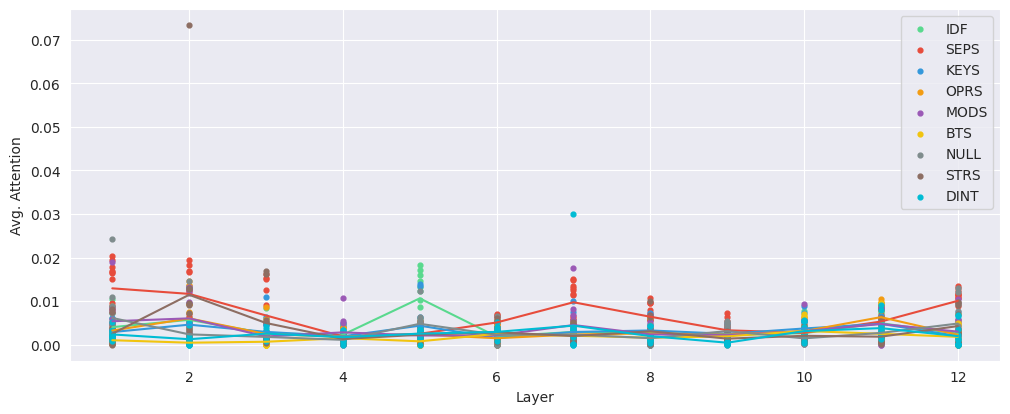

In [121]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer][head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")
  

plt.figure(figsize=(12, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [("identifier", GREEN, "IDF"),("separator", RED, "SEPS"), ("keyword", BLUE, "KEYS"), ("operator", ORANGE, "OPRS"), ("modifier", PURPLE, "MODS"), ("basictype", YELLOW, "BTS"), ("null", GRAY, "NULL"), ("string", BROWN, "STRS"), ("decimalinteger", CYAN, "DINT")]:
  add_line(key, ax, color, label, plot_avgs=True)

In [2]:
import pickle 

In [5]:
# load pickle file
a = pickle.load(open("/home/fjiriges/CodeXGLUE/Code-Code/Clone-detection-BigCloneBench/code/syntax_attention_weights_finetuned.pkl", "rb"))

In [6]:
len(a)

200

In [7]:
syntax_list = ['annotation', 'basictype', 'boolean', 
          'decimalinteger', 'identifier', 'keyword',
          'modifier', 'operator', 'separator', 'null',
          'string', 'decimalfloatingpoint']